In [13]:
from dotenv import load_dotenv

load_dotenv()

True

In [14]:
query = "인프런에는 어떤 강의가 있나요 ?"

In [ ]:
# Langchain
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

llm.invoke(query)

AIMessage(content='인프런(Inflearn)은 다양한 온라인 강의를 제공하는 플랫폼으로, 주로 IT, 프로그래밍, 데이터 과학, 디자인, 마케팅, 비즈니스 등 여러 분야의 강의를 제공합니다. 예를 들어:\n\n1. **프로그래밍**: Python, Java, JavaScript, C++, 웹 개발, 모바일 앱 개발 강의\n2. **데이터 과학**: 머신러닝, 데이터 분석, 데이터베이스, 빅데이터 관련 강의\n3. **디자인**: UX/UI 디자인, 그래픽 디자인, 포토샵, 일러스트레이터 강의\n4. **마케팅**: 디지털 마케팅, SEO, 소셜미디어 마케팅 관련 강의\n5. **비즈니스**: 스타트업, 경영, 재무 관리 관련 강의\n\n각 강의는 초급, 중급, 고급 수준으로 나뉘며, 영상, 교재, 실습 자료 등이 제공됩니다. 인프런 웹사이트를 통해 다양한 강의를 직접 확인하고 수강할 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 227, 'prompt_tokens': 18, 'total_tokens': 245, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C14yrPezzelwRSRgc4BOzQKSAWNI9', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': N

In [ ]:
# LangGraph
"""
State, Node, Edge, Conditional Edge 로 구성됨
State : 현재 Agent의 상태
Node : Agent가 수행하는 작업, 함수
- RAG의 경우 query, retrieve, generate
Edge, Conditional Edge : 노드와의 관계
- retrive의 경우 Conditional edge를 통해 rewrite할지 generate할지 판단
  - langchain에서는 수정할 필요가 없어도 rewrite 로직을 무조건 탄다
  - langraph의 retrieve는 수정할 필요 없으면 rewrite 로직을 타지 않는다
"""
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage # SystemMessage, HumanMessaage, AIMessage's type

class AgentState(TypedDict):
  message: list[Annotated[AnyMessage, add_messages]] 

In [5]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

In [6]:
# Node
def generate(state: AgentState):
    message = state["message"]
    ai_message = llm.invoke(message)
    return {"message": [ai_message]}

In [7]:
from langgraph.graph import START, END

graph_builder.add_node("generate", generate)

In [ ]:
graph_builder.add_edge(START, "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile() # Make graph

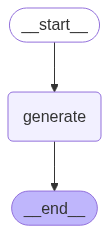

In [10]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
from langchain_core.messages import HumanMessage 

initial_state = {"message": [HumanMessage(query)]}
graph.invoke(initial_state)

{'message': [AIMessage(content='인프런은 다양한 온라인 강의를 제공하는 플랫폼으로, 주로 프로그래밍, 데이터 과학, 디자인, 마케팅, 그리고 IT 관련 주제들을 다루고 있습니다. 인기 있는 강의 카테고리는 다음과 같습니다:\n\n1. **프로그래밍:** Python, Java, JavaScript, C++, 웹 개발, 모바일 앱 개발 등의 강의.\n2. **데이터 과학:** 데이터 분석, 머신러닝, 인공지능, R과 Python을 이용한 데이터 처리.\n3. **디자인:** UX/UI 디자인, 그래픽 디자인, 디자인 툴 사용법(예: 포토샵, 스케치 등).\n4. **마케팅:** 디지털 마케팅, SEO, 소셜 미디어 마케팅, 콘텐츠 마케팅.\n5. **IT 및 클라우드:** 시스템 관리, 클라우드 서비스(AWS, Azure, GCP), 네트워크 관리.\n\n각 강의는 강사에 따라 다르며, 수강자는 자신의 수준과 필요에 맞는 강의를 선택할 수 있습니다. 또한, 실습 위주의 프로젝트와 커뮤니티 토론도 제공되어 학습 효과를 높일 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 245, 'prompt_tokens': 18, 'total_tokens': 263, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C14zAV1o9VDHJ

# Langchain으로만 충분히 서비스를 만들 수 있는지 충분히 검증이 필요
- 위 처럼 LLM 호출만 하는 경우에는 Lang graph는 over engineering 될 수 있다